In [61]:
! pip install wandb

In [62]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
from keras.datasets import fashion_mnist
import seaborn as sn
import pandas as pd

In [63]:
(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()

In [64]:
# showed=np.zeros(10)
# i=0
# images=[]
# classes=[]
# while (0 in showed):
#   i=np.random.randint(0,len(y_train))
#   if showed[y_train[i]]==0:
#     images.append(im.fromarray(x_train[i]))
#     classes.append(y_train[i])
#     showed[y_train[i]]=1
#   i=i+1

In [65]:
# plt.figure(figsize=(10, 10))
# for i, image in enumerate(images):
#   img=plt.subplot(3, 5,i+1)
#   img.set_title(classes[i])
#   plt.imshow(image,cmap='gray')

## FeedForward Neural Network

In [66]:
samples=int(len(x_train)-0.1*len(x_train))
X_train=x_train[0:samples]
Y_train=y_train[0:samples]
X_val=x_train[samples:len(x_train)]
Y_val=y_train[samples:len(x_train)]
print(X_train.shape,X_val.shape)

(54000, 28, 28) (6000, 28, 28)


In [67]:
  epoch=5
  layers=3
  hid_size=64
  eta=1e-4
  batch_size=128
  wt_init = 'Xavier'
  act = 'ReLu'
  wt_decay = 0

In [68]:
# sweep_id = wandb.sweep(sweep_config, entity="piyushac123", project="Feed_Forward_Neural_Network_modules")

In [69]:
def init_w_and_b():
  # print('b')
  neurons=[len(X_train[0].reshape(784))]
  for i in range(1,layers): neurons.append(hid_size)
  neurons.append(10)
  #print(neurons)
  w=[]
  b=[]
  if(wt_init== 'random'):
    for i in range(1,layers+1):
      wx=np.random.rand(neurons[i],neurons[i-1])
      w.append(wx)
    for i in range(1,layers+1):
      bx=np.random.rand(neurons[i])
      b.append(bx)

  if(wt_init== 'Xavier'):
    var=2/(neurons[0]+neurons[layers])
    mu=0
    for i in range(1,layers+1):
      wx=np.random.normal(mu,var,(neurons[i],neurons[i-1]))
      w.append(wx)
    for i in range(1,layers+1):
      bx=np.random.normal(mu,var,neurons[i])
      b.append(bx)
  
  return neurons, w, b

In [70]:
def activation_func(a1, choice):
    if(choice == 'sigmoid'):
      return (1/(1+np.exp(-a1)))
    if(choice=='tanh'):
      return (2/(1+np.exp(-2*a1))-1)
    if(choice=='ReLu'):
      return np.multiply(1*(a1>=0),a1)

In [71]:
def activation_func_derivative(a,choice):
  if(choice == 'sigmoid'):
      return activation_func(a,choice)*(1-activation_func(a,choice))
  if(choice=='tanh'):
    return 1-np.square(activation_func(a,choice))
  if(choice=='ReLu'):
    return 1*(a>=0)

In [72]:
def get_test_accuracy(w,b):
  match=0
  for i in range(len(y_test)):
    yhat=predict(w,b,x_test[i].reshape(784))
    if(np.argmax(yhat)==y_test[i]):
      match+=1
  return match/len(y_test)

In [73]:
def get_val_accuracy(w,b):
  match=0
  for i in range(len(Y_val)):
    yhat=predict(w,b,X_val[i].reshape(784))
    if(np.argmax(yhat)==Y_val[i]):
      match+=1
  return match/len(Y_val)

In [74]:
def get_accuracy(w,b):
  match=0
  for i in range(len(Y_train)):
    yhat=predict(w,b,X_train[i].reshape(784))
    if(np.argmax(yhat)==Y_train[i]):
      match+=1
  return match/len(Y_train)

In [75]:
def val_cross_entropy(w,b):
  err=0
  for i in range(len(Y_val)):
    yhat=predict(w,b,X_val[i].reshape(784))
    err+=-np.log(yhat[Y_val[i]])
  l2norm=0
  for i in range(len(w)):
    l2norm+=np.linalg.norm(w[i])

  return err/len(Y_val)+l2norm*wt_decay/(2*len(Y_val))

In [76]:
def cross_entropy(w,b):
  err=0
  for i in range(len(Y_train)):
    yhat=predict(w,b,X_train[i].reshape(784))
    err+=-np.log(yhat[Y_train[i]])
  l2norm=0
  for i in range(len(w)):
    l2norm+=np.linalg.norm(w[i])

  return err/len(Y_train)+l2norm*wt_decay/(2*len(Y_train))

In [77]:
def predict(w,b,img):
  a=b[0]+np.dot(w[0],img)
  h=activation_func(a, act) 

  for i in range(1,layers-1):
    a=b[i]+np.dot(w[i],h)
    h=activation_func(a, act)   
  lastLayer=b[layers-1]+np.dot(w[layers-1],h)
  y=softmax(lastLayer)
  return y

In [78]:
def softmax(a):
  return np.exp(a)/sum(np.exp(a))

In [79]:
def forward_prop(w,b,p):
  # print('c')
  h=[]
  a=[]
  a1=b[0]+np.dot(w[0],X_train[p].reshape(784))
  a.append(a1)
  h1 = activation_func(a1, act)
  h.append(h1)
  for i in range(1,layers-1):
    a1=b[i]+np.dot(w[i],h[i-1])
    a.append(a1)
    h1=activation_func(a1, act) 
    h.append(h1)
  a1=b[layers-1]+np.dot(w[layers-1],h[layers-2])######Repeat
  a.append(a1)
  y=softmax(a1)
  return h,a,y

In [80]:
def backward_prop(h,a,y,p,w,b):
  # print('e')
  wdash=[]
  bdash=[]
  actualY=np.zeros(10)
  actualY[Y_train[p]]=1
  dela=y-actualY

  for i in range(0,layers-1):
    delw=np.outer(dela,h[layers-2-i])
    wdash.append(delw)
    bdash.append(dela)
    delh=np.dot(w[layers-1-i].T,dela)
    #g=(1/(1+np.exp(-a[layers-1-i-1])))   #chnge to actvatn derivative ???????????????????????
    gdash=activation_func_derivative(a[layers-1-i-1],act)
    dela=np.multiply(delh,gdash)
  
  delw=np.outer(dela,X_train[p])
  wdash.append(delw)
  bdash.append(dela)
  wdash.reverse()
  bdash.reverse()
  return wdash,bdash


### Stochastic Gradient Descent

In [81]:
def stocastic_gd():

  neurons, w, b = init_w_and_b()

  #s=len(x_train)
  error=[]
  val_error=[]
  accuracy=[]
  val_accuracy=[]
  mse=[]
  val_mse=[]
  test_accuracy=[]
  for i in range(0,epoch):
    wgrad=[]
    bgrad=[]
    bs=0
    for j in range(0,samples):
      bs+=1
      h,a,y=forward_prop(w,b,j)
      wdash,bdash=backward_prop(h,a,y,j,w,b)
      wgrad.append(wdash)
      bgrad.append(bdash)
      if bs%batch_size==0:
        w=np.subtract(w,eta*np.sum(wgrad,axis=0))
        b=np.subtract(b,eta*np.sum(bgrad,axis=0))
        wgrad.clear()
        bgrad.clear()
    error.append(cross_entropy(w,b))
    val_error.append(val_cross_entropy(w,b))
    accuracy.append(get_accuracy(w,b))
    val_accuracy.append(get_val_accuracy(w,b))
    # mse.append(mean_squared_error(w,b))
    # val_mse.append(val_mean_squared_error(w,b))
    test_accuracy.append(get_test_accuracy(w,b))
  return w,b,error,val_error,accuracy,val_accuracy,test_accuracy
  # img_num=np.random.randint(0,len(y_test))
  # y_hat=predict(w,b,x_test[img_num])
  # print("probabilities of each class:",y_hat)

In [82]:
w,b,error,val_error,accuracy,val_accuracy,test_accuracy = stocastic_gd()
print("error :",error)
print("val_error :",val_error)
print("accuracy :",accuracy)
print("val_accuracy :",val_accuracy)
print("test_accuracy :",test_accuracy)

    
    #error=cross_entropy(w,b,wandb.config)
    #wandb.log()
    # print(w)
    # print(b)
    # wandb.finish()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

error : [0.6438988174230796, 0.49179255119780024, 0.42836466846721943, 0.4189342872488652, 0.4007872469913795]
val_error : [0.6491240711986834, 0.5091940321584658, 0.4481063734305205, 0.4458673004282699, 0.4324026812507207]
accuracy : [0.7712592592592593, 0.8108518518518518, 0.8437037037037037, 0.8417962962962963, 0.851037037037037]
val_accuracy : [0.7666666666666667, 0.7973333333333333, 0.832, 0.8276666666666667, 0.8378333333333333]
test_accuracy : [0.7569, 0.8001, 0.8291, 0.8272, 0.8317]


In [83]:
arr_conf = np.array([[0 for _ in range(10)] for _ in range(10)])
arr_conf.shape

(10, 10)

In [84]:
    y_val_predict = []
    for i in range(len(Y_val)):
      y_val_predict.append(np.argmax(predict(w,b,X_val[i].reshape(784))))
    print(y_val_predict)

    for i in range(len(y_val_predict)):
        arr_conf[Y_val[i]][y_val_predict[i]] +=1
        # print(Y_val[i], y_val_predict[i])
    print(arr_conf)
    # y_val_probs = [0 for _ in range(0,10)]
    # for i in range(len(Y_val)):
    #   y_val_probs[y_val_predict[i]] +=1
    # np.divide(y_val_probs,len(Y_val))

[7, 4, 3, 6, 4, 7, 3, 4, 3, 1, 0, 2, 0, 5, 2, 3, 7, 3, 8, 8, 2, 3, 5, 0, 0, 0, 9, 0, 9, 2, 2, 0, 3, 3, 2, 1, 7, 7, 0, 0, 8, 9, 8, 2, 9, 7, 1, 3, 8, 5, 9, 7, 0, 0, 2, 2, 9, 7, 0, 4, 7, 8, 3, 0, 5, 0, 3, 7, 9, 6, 0, 8, 1, 8, 2, 0, 0, 0, 3, 4, 7, 0, 7, 7, 7, 3, 8, 7, 2, 8, 8, 5, 0, 3, 2, 7, 4, 7, 1, 5, 5, 3, 7, 0, 9, 3, 5, 4, 2, 5, 0, 5, 2, 3, 0, 2, 0, 3, 0, 0, 7, 6, 0, 0, 8, 4, 5, 4, 9, 1, 9, 0, 2, 3, 3, 3, 9, 0, 2, 8, 0, 2, 8, 1, 1, 0, 3, 2, 0, 8, 8, 7, 4, 5, 9, 0, 0, 3, 7, 0, 5, 4, 7, 0, 0, 2, 7, 5, 2, 7, 4, 8, 9, 2, 4, 2, 2, 1, 8, 2, 2, 8, 0, 5, 2, 5, 4, 9, 2, 0, 4, 5, 4, 9, 2, 8, 7, 6, 3, 9, 8, 2, 8, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 5, 4, 7, 2, 8, 6, 0, 2, 0, 2, 8, 2, 1, 0, 0, 3, 0, 5, 2, 2, 8, 0, 2, 4, 1, 9, 7, 8, 8, 5, 9, 9, 3, 5, 6, 4, 8, 5, 2, 7, 3, 5, 1, 4, 2, 2, 7, 9, 2, 0, 0, 9, 0, 1, 0, 1, 2, 9, 9, 0, 7, 0, 4, 3, 3, 0, 4, 5, 8, 0, 0, 8, 8, 5, 2, 5, 6, 0, 1, 6, 8, 9, 3, 5, 4, 8, 4, 4, 4, 3, 2, 4, 8, 4, 2, 7, 9, 4, 2, 1, 9, 0, 4, 4, 3, 0, 8, 7, 1, 0, 9, 3, 7, 8, 3, 0, 9, 6, 4, 0, 

In [85]:
df_conf = pd.DataFrame(arr_conf, index = ["T-shirt/top","Trouser","Pullover","Dress","Coat", "Sandal","Shirt","Sneaker","Bag","Ankle boot"],
                  columns = ["T-shirt/top","Trouser","Pullover","Dress","Coat", "Sandal","Shirt","Sneaker","Bag","Ankle boot"])
df_conf.index.name = 'Actual'
df_conf.columns.name = 'Predicted'
df_conf

Predicted,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Actual,,,,,,,,,,
T-shirt/top,575,0,14,20,2,1,16,0,2,0
Trouser,0,556,7,17,2,0,2,0,0,0
Pullover,10,1,538,5,30,0,14,0,4,0
Dress,26,5,9,530,29,0,3,1,2,0
Coat,0,1,200,20,396,0,14,0,2,0
Sandal,1,0,0,0,0,557,0,19,6,8
Shirt,161,1,105,15,67,0,210,0,6,0
Sneaker,0,0,0,0,0,17,0,522,0,16
Bag,3,0,7,1,6,5,16,5,573,0


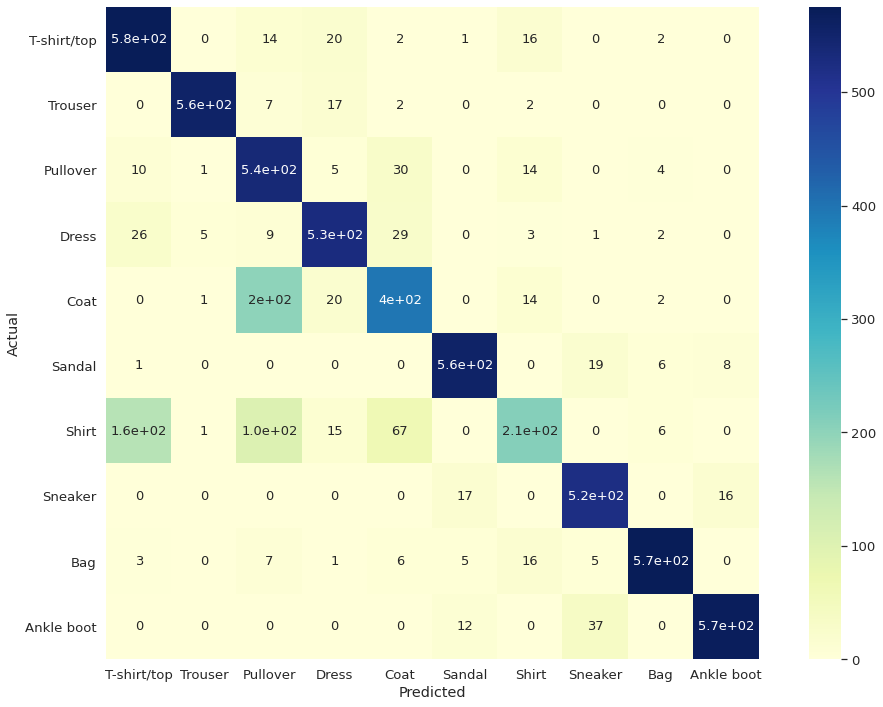

In [86]:
plt.subplots(figsize = (18,12))
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_conf, cmap="YlGnBu", annot=True,annot_kws={"size": 13}, square=True)# font size

In [87]:
data = {'accuracy' : test_accuracy}
df = pd.DataFrame(data)
print(df)

   accuracy
0    0.7569
1    0.8001
2    0.8291
3    0.8272
4    0.8317


Text(0, 0.5, 'Test Accuracy')

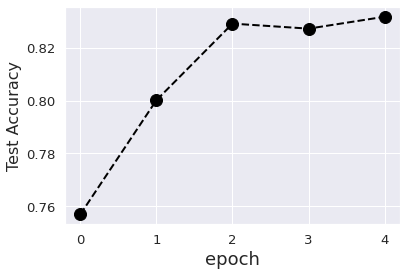

In [88]:
# sn.lineplot(x="h", y="i", data=df)
plt.plot(df, color='black', marker='o', linestyle='dashed',linewidth=2, markersize=12)
plt.xlabel('epoch', fontsize=18)
plt.ylabel('Test Accuracy', fontsize=16)